In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
""" from sklearn.preprocessing import LabelEncoder
from scipy import interpolate """
import joblib

# Import data

Chargement des corrdonnées des oreilles 

In [51]:
X_ear = pd.pandas.read_csv("E:/UQAM/Recherche/Thomas/data/ear_position.csv",  header=None)
X_ear


,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
1370,0.0,0.0,1.0
1371,0.0,0.0,1.0
1372,0.0,0.0,1.0
1373,0.0,0.0,1.0


' plt.subplot(2,2,4)\nplt.plot(range(0,len(X_ear)) ,X_ear[3]) '

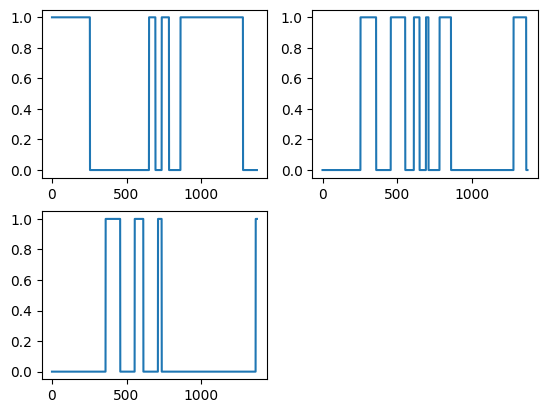

In [52]:
plt.subplot(2,2,1)
plt.plot(range(0,len(X_ear)) , X_ear[0])
plt.subplot(2,2,2)
plt.plot(range(0,len(X_ear)) ,X_ear[1])
plt.subplot(2,2,3)
plt.plot(range(0,len(X_ear)) ,X_ear[2])
""" plt.subplot(2,2,4)
plt.plot(range(0,len(X_ear)) ,X_ear[3]) """


0    0.557091
1    0.304727
2    0.138182
dtype: float64


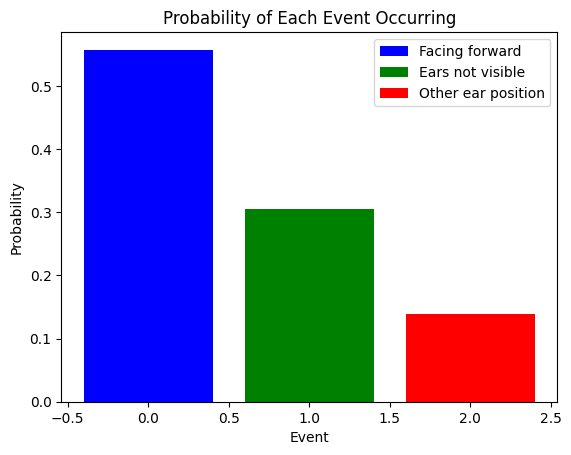

In [53]:
df = pd.DataFrame(X_ear)
df
# Plot all columns in one plot with different colors
""" fig, ax = plt.subplots()
for col in df.columns:
    ax.plot(df.index, df[col], label=f'Column {col}')
ax.legend()
plt.show() """

# Calculate the probability for each event (column)
event_probabilities = df.mean()  # Calculate the mean of each column to get the probability
print(event_probabilities)
# Plot the probabilities
bars = plt.bar(event_probabilities.index, event_probabilities.values, color=['blue', 'green', 'red'])
plt.xlabel('Event')
plt.ylabel('Probability')
plt.title('Probability of Each Event Occurring')
# Add a legend with explicit handles and labels
plt.legend(handles=bars, labels=['Facing forward', 'Ears not visible', 'Other ear position'])
plt.show()

Lissage des donnees

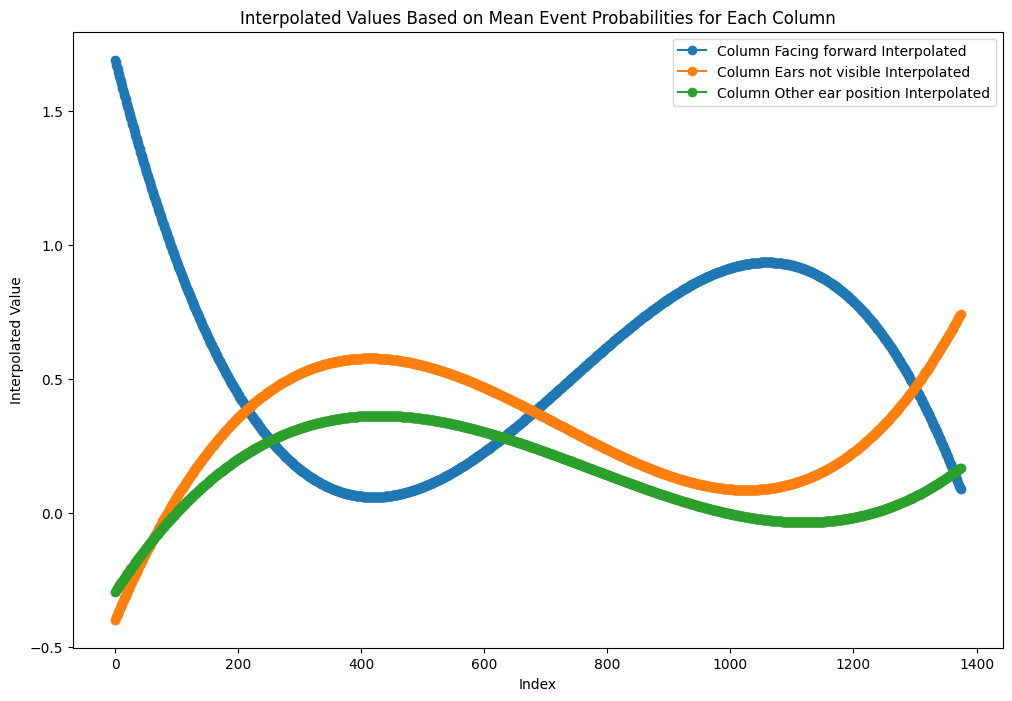

In [54]:

# Perform linear interpolation
""" print(df.index)
print(df.columns)
tmp_data = df.index
print(tmp_data.shape)
print(df[1].shape)
interpolated_data = pd.DataFrame({col: interpolate.interp1d(tmp_data, df[col], kind='slinear')(tmp_data) for col in df.columns})

# Plot the original and interpolated data
plt.figure(figsize=(10, 6))
for col in df.columns:
    plt.plot(df.index, df[col], 'o-', label=f'Original {col}')
    plt.plot(df.index, interpolated_data[col], label=f'Interpolated {col}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Original and Interpolated Data')
plt.legend()
plt.show() """

labels=['Facing forward', 'Ears not visible', 'Other ear position']
# Perform interpolation based on the mean event probabilities for each column
interpolated_values = {}
x = np.arange(len(df))  # Create x values for interpolation
for col in df.columns:
    poly = np.poly1d(np.polyfit(x, df[col], 3))  # Use a 3rd degree polynomial
    interpolated_values[col] = poly(x)

for key,n_key in zip(interpolated_values.keys(), labels):
    interpolated_values[n_key] = interpolated_values.pop(key)

# Plot the interpolated values for each column separately
plt.figure(figsize=(12, 8))
for col, values in interpolated_values.items():
    plt.plot(values, label=f'Column {col} Interpolated', marker='o')
plt.xlabel('Index')
plt.ylabel('Interpolated Value')
plt.title('Interpolated Values Based on Mean Event Probabilities for Each Column')
plt.legend()
plt.show()

# Train model

In [58]:

scores = list()
models = list()
X_interpolated_ear = pd.DataFrame.from_dict(interpolated_values)
print(X_interpolated_ear)
""" le = LabelEncoder()

model = hmm.MultinomialHMM(n_components=3, n_iter=100)
model.fit(np.array(X_ear)) """


for n_components in range(2, 5): # test 2 to 5 n components
    for idx in range(10):  # ten different random starting states
        # define our hidden Markov model
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx,covariance_type = "diag", n_iter=42)
        model.fit(X_interpolated_ear)
        models.append(model)
        scores.append(model.score(X_interpolated_ear))
        # print(f'Converged: {model.monitor_.converged}\t\t'f'Score: {scores[-1]}')

# get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and 'f'{model.n_components} components')

# use the Viterbi algorithm to predict the most likely sequence of states
# given the model

Z = model.predict(X_interpolated_ear)

# Save the model object to a file
joblib.dump(model, 'models/hmm_model_ear.pkl')
model

      Facing forward  Ears not visible  Other ear position
0           1.690831         -0.397702           -0.293130
1           1.681896         -0.392265           -0.289631
2           1.672990         -0.386846           -0.286144
3           1.664114         -0.381446           -0.282668
4           1.655268         -0.376064           -0.279203
...              ...               ...                 ...
1370        0.112119          0.725729            0.162152
1371        0.106163          0.729961            0.163876
1372        0.100181          0.734210            0.165609
1373        0.094174          0.738475            0.167350
1374        0.088142          0.742758            0.169100

[1375 rows x 3 columns]
The best model had a score of 5332.743582059371 and 4 components


GaussianHMM(n_components=4, n_iter=42, random_state=2)

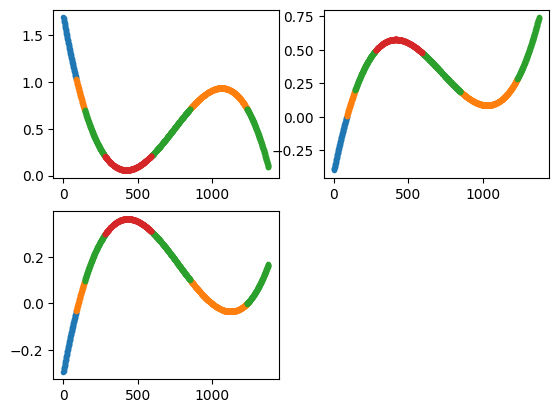

In [56]:
states= pd.unique(Z)

plt.subplot(2,2,1)
for i in states:
    x = np.linspace(1,1375,1375)[(Z == i)]
    y = X_interpolated_ear['Facing forward'][(Z == i)]
    plt.plot(x, y, '.')
plt.subplot(2,2,2)
for i in states:
    x = np.linspace(1,1375,1375)[(Z == i)]
    y = X_interpolated_ear['Ears not visible'][(Z == i)]
    plt.plot(x, y, '.')
plt.subplot(2,2,3)
for i in states:
    x = np.linspace(1,1375,1375)[(Z == i)]
    y = X_interpolated_ear['Other ear position'][(Z == i)]
    plt.plot(x, y, '.')


In [57]:
df=pd.DataFrame({'states':Z})
df.to_csv("E:/UQAM/Recherche/Thomas/data/ear_coords_hmmstates.csv")